## Input for MITgcm channel simulations

For the base simulation we need to generate a few files, the following: 
- Bathymetry
- Surface winds
- Surface buoyancy (temperature) restoration
- Initial condition for temperature field.

In addition we can also use:
- Sponge layer profile. Use this if you want to control the interior stratification with more precision. An effect having this turned on is that a residual circulation will be present. 
- Sponge layer mask, comes with the profile. 


In [1]:
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
output_dir = './' # where to store these input file

resolution = 20e3 # km

# Domain
Lx = 2e6
Ly = 2e6

# Winds
tau0 = 0.2 # N/m^2 wind maxima
Buff_L = 50e3  # Total buffer width on both side where wind goes to 0
wind_type = 'Sin_sqr'

# Surface temp
Tmin, Tmax = 0., 8.0 # min, max temperature of linear surface profile

# Bathymetry
H = 3000.0 # m depth
h0 = 1000.0 # Height of ridge
sig = 75.0e3 # Width of ridge (gaussian standard deviation)


# Sponge layer and initial conditions
delT = Tmax - Tmin
Hs = 1200.
a = 1e-5
b = -19


# Other parameters
flag = 1 # set 0 to not generate any plots
tp = '>f8'

#### Generate grid 

In [3]:
# A function that makes xy grid
def make_grid_xy(lx, ly, res):
#    lx, ly = length, length
#    nx, ny = n, n
    nx = int(lx/res)
    ny = int(ly/res)
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc, dx, dy

In [4]:
xc, yc, dx, dy = make_grid_xy(Lx, Ly, resolution)

In [5]:
# Z grid 
# At the moment this is manually input, and support to be the same as the LLC4320 grid
delR =   np.array([1.00,    1.14,    1.30,    1.49,   1.70,  
                   1.93,    2.20,    2.50,    2.84,   3.21,        
                   3.63,    4.10,    4.61,    5.18,   5.79,   
                   6.47,    7.20,    7.98,    8.83,   9.73,  
                   10.69,   11.70,   12.76,   13.87,  15.03,   
                   16.22,   17.45,   18.70,   19.97,  21.27,    
                   22.56,   23.87,   25.17,   26.46,  27.74,  
                   29.00,   30.24,   31.45,   32.65,  33.82, 
                   34.97,   36.09,   37.20,   38.29,  39.37,   
                   40.45,   41.53,   42.62,   43.73,  44.87,
                   46.05,   47.28,   48.56,   49.93,  51.38,
                   52.93,   54.61,   56.42,   58.38,  60.53,
                   62.87,   65.43,   68.24,   71.33,  74.73,
                   78.47,   82.61,   87.17,   92.21,  97.79,
                   103.96,  110.79,  118.35,  126.73, 136.01, 174.67])
Z = -(delR.cumsum())

# Z grid for 40 points
# I think it is ok to use this, unless we are going to higher resolutions. 
delR= np.array([10.0, 10.0, 10.0, 12.0, 
                14.0, 16.0, 19.0, 22.0, 
                26.0, 30.0, 36.0, 42.0, 
                50.0, 60.0, 72.0, 85., 102., 
                103., 103., 103., 103., 
                103., 103., 103., 103., 
                103., 103., 103., 103., 
                103., 103., 103., 103., 
                103., 103., 103., 103., 
                103., 103., 103.])
Z = -(delR.cumsum())


### Surface forcing fields

#### Winds

In [6]:
#tau = np.zeros([ny,nx])

if wind_type=='Sin_sqr':
# Sin^2 
    tau = tau0*(np.sin(np.pi* (yc-Buff_L)/(Ly-2*Buff_L))**2) # slightly squeezed wind profile to account 

# Add buffer zone of 0 winds on domain end
tau[yc<=Buff_L] = 0.
tau[yc>=(Ly-Buff_L)] = 0.

tau.astype(tp).tofile((output_dir + 'surf_winds'+'_'+wind_type+'_%01d_em1_Nm2_%03d.bin'%(tau0*10,resolution)))
   

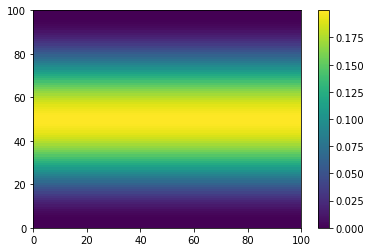

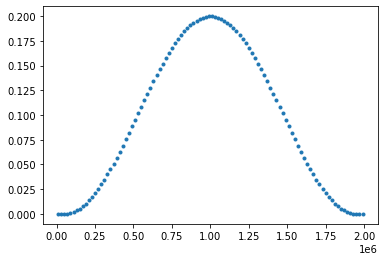

In [7]:
if flag ==1 :
    plt.pcolor(tau)
    plt.colorbar()

    plt.figure()
    plt.plot(yc[:,1],tau[:,1],'.')
    

#### Surface temperature

In [8]:
ny = int(Ly/resolution)
Tsurf = np.tile(np.linspace(Tmin, Tmax, ny), (ny,1)).T

Tsurf.astype(tp).tofile((output_dir + 'surf_temp_linear_%1d_to_%1dC_%03d.bin' %(Tmin, Tmax, resolution)))

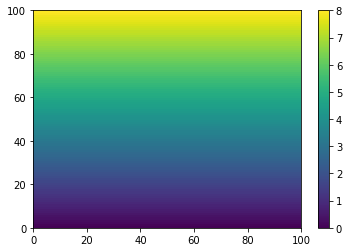

In [9]:
flag = 1
if flag == 1:
    plt.pcolor(Tsurf)
    plt.colorbar()

### Bathymetry

In [10]:
bathy = -(H - h0 * np.exp(-(xc - Lx/2)**2 / sig**2))

bathy[0,:] = 0.0 # make a wall 

bathy.astype(tp).tofile(output_dir + 'bathymetry_ridge_%03d.bin' % resolution)

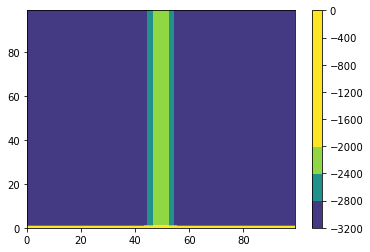

In [11]:
if flag == 1:
    plt.contourf((bathy), vmax=-2000)
    plt.colorbar()

### Initial condition

In [12]:
# this part only runs on gyre at the moment, since that is where the 5km data lives.
#spinup_old = '/swot/SUM05/dbalwada/channel_beta/05km/run_spinup_256_300s_autorestart/'
#ds_05_old = open_mdsdataset(spinup_old, iters = [11923200],delta_t=300, prefix=['T'],ignore_unknown_vars=True, geometry='cartesian')

In [13]:
#init_temp = ds_05_old['T'].isel(time=0).values

In [14]:
#init_temp.astype(tp).tofile(output_dir + 'temp_initial_05km_old_%03d.bin' % resolution)

### Sponge layer

In [15]:
T_sponge_profile = delT*(np.exp(Z/Hs) - np.exp(Z[-1]/Hs)
                        )/(np.exp(0./Hs) - np.exp(Z[-1]/Hs))
n = int(Ly/resolution)

T_sponge = np.tile(T_sponge_profile, (n,n,1)).T
T_sponge = T_sponge+0.01

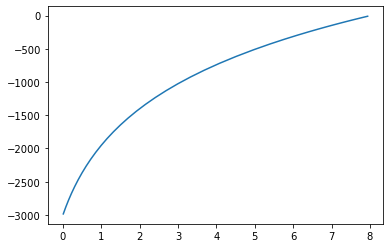

In [16]:
plt.plot(T_sponge[:, 3,3], Z)

In [17]:
T_sponge_mask = np.ones_like(T_sponge)*yc
T_sponge_mask = a*T_sponge_mask + b
T_sponge_mask[T_sponge_mask<0] = 0.

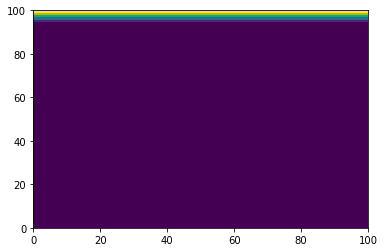

In [18]:
plt.pcolormesh(T_sponge_mask[3,:,:])

In [19]:
plt.pl

AttributeError: module 'matplotlib.pyplot' has no attribute 'pl'

In [ ]:
T_sponge.astype(tp).tofile(output_dir + 
                           'temp_relax_profile_sponge_%03d.bin' % resolution)

In [ ]:
T_sponge_mask.astype(tp).tofile(output_dir + 
                           'temp_relax_mask_sponge_%03d.bin' % resolution)

In [ ]:
# save initial conditions as the same profile as sponge layer everywhere. 
T_sponge.astype(tp).tofile(output_dir + 'temp_initial_%03d.bin' % resolution)